In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os

In [2]:
# ==== SETUP ====
img_size = (224, 224)
batch_size = 32
num_classes = 15
train_dir = 'C:/Users/Sinta/Documents/Larskar AI/Capstone/prediksi_penyakit_tanaman/dataset/data_potato/Training'
val_dir = 'C:/Users/Sinta/Documents/Larskar AI/Capstone/prediksi_penyakit_tanaman/dataset/data_potato/Validation'
test_dir = 'C:/Users/Sinta/Documents/Larskar AI/Capstone/prediksi_penyakit_tanaman/dataset/data_potato/Testing'

# ==== DATA AUGMENTATION ====
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse'  # Gunakan 'sparse' jika label berupa angka
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)

Found 3251 images belonging to 3 classes.
Found 416 images belonging to 3 classes.
Found 405 images belonging to 3 classes.


In [3]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=img_size + (3,)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# ==== COMPILE ====
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ==== CALLBACKS ====
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

In [4]:

# ==== TRAIN INITIAL ====
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/15
102/102 [==============================] - 289s 3s/step - loss: 1.1650 - accuracy: 0.4562 - val_loss: 0.9184 - val_accuracy: 0.5721 - lr: 0.0010
Epoch 2/15
102/102 [==============================] - 196s 2s/step - loss: 0.8292 - accuracy: 0.6481 - val_loss: 0.6166 - val_accuracy: 0.7524 - lr: 0.0010
Epoch 3/15
102/102 [==============================] - 207s 2s/step - loss: 0.6913 - accuracy: 0.7259 - val_loss: 0.4960 - val_accuracy: 0.8462 - lr: 0.0010
Epoch 4/15
102/102 [==============================] - 212s 2s/step - loss: 0.6178 - accuracy: 0.7527 - val_loss: 0.3945 - val_accuracy: 0.8798 - lr: 0.0010
Epoch 5/15
102/102 [==============================] - 214s 2s/step - loss: 0.5263 - accuracy: 0.7964 - val_loss: 0.3969 - val_accuracy: 0.8462 - lr: 0.0010
Epoch 6/15
102/102 [==============================] - 185s 2s/step - loss: 0.4888 - accuracy: 0.8096 - val_loss: 0.4128 - val_accuracy: 0.8413 - lr: 0.0010
Epoch 7/15
102/102 [==============================] - 183s 2s/st

In [5]:
# ==== EVALUATION ====
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc:.4f}")

# ==== SAVE MODEL ====
model.save('C:/Users/Sinta/Documents/Larskar AI/Capstone/AgroVA-app/models/predict_disease_model_potato.h5')

13/13 [==============================] - 10s 762ms/step - loss: 0.1672 - accuracy: 0.9457

Test Accuracy: 0.9457


13/13 [==============================] - 5s 390ms/step
              precision    recall  f1-score   support

Early_Blight       0.92      0.96      0.94       162
     Healthy       0.97      0.89      0.93       102
 Late_Blight       0.96      0.96      0.96       141

    accuracy                           0.95       405
   macro avg       0.95      0.94      0.94       405
weighted avg       0.95      0.95      0.95       405



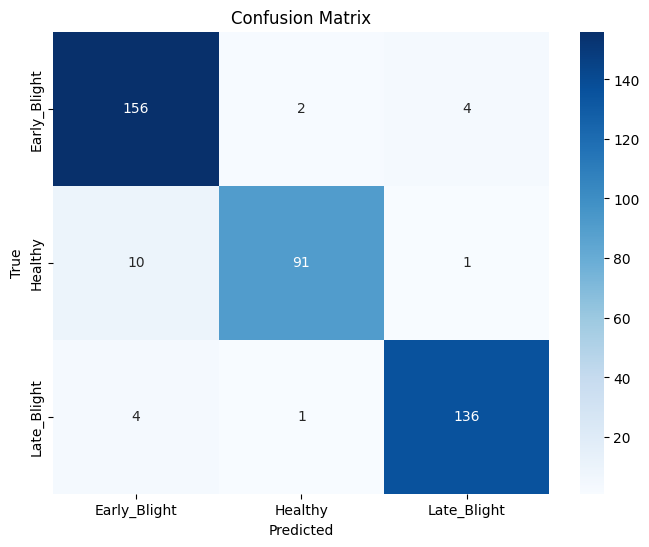

In [6]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Prediksi
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [8]:
# Convert .h5 ke tflite_model
import tensorflow as tf

# Ganti dengan path model kamu
model = tf.keras.models.load_model('C:/Users/Sinta/Documents/Larskar AI/Capstone/AgroVA-app/models/predict_disease_model_potato.h5')

In [9]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('C:/Users/Sinta/Documents/Larskar AI/Capstone/AgroVA-app/models/predict_model_disease_potato.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Sinta\AppData\Local\Temp\tmptti6irgj\assets


INFO:tensorflow:Assets written to: C:\Users\Sinta\AppData\Local\Temp\tmptti6irgj\assets
